In [991]:
import pandas as pd
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imblearn

from wordcloud import WordCloud
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import word2vec

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

In [992]:
only_english = set(nltk.corpus.words.words())
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

# Functions definition

In [993]:
def save_file(d, n):
    d.to_csv('../data/processed/' + n +'.csv')


In [994]:
def clean_text(text):    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub('\w*\d\w*', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip() #remove empty spaces at the begining and end of the sentence
    sample = " ".join([x.strip() for x in sample.split()])#remove empty spaces at the begining and end of each word
    return sample

In [995]:
def get_wordnet_pos(word):
    treebank_tag = nltk.pos_tag([word])[0][1]
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [996]:
def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if word not in stops]
    sample = ' '.join(sample)
    
    if lemma:
        new_sample = []
        sample = sample.split()
        word_tags = [get_wordnet_pos(word.lower()) for word in sample]
        for word in sample:
            word_tag = word_tags[sample.index(word)]
            if word_tag == "":
                new_sample.append(lemmatizer.lemmatize(word))
            else:
                new_sample.append(lemmatizer.lemmatize(word.lower(), word_tag))
        sample = ' '.join(new_sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [997]:
def scale(z_train, z_test):
    scaler = MinMaxScaler()
    z_train_scaled = pd.DataFrame(scaler.fit_transform(z_train), columns=z_train.columns)  
    z_test_scaled =  pd.DataFrame(scaler.fit_transform(z_test), columns=z_test.columns) 
    return z_train_scaled, z_test_scaled

In [998]:
def get_vectorizer(v):
    if(v=='bow'):
        v=CountVectorizer(max_features=50)
    else:
        v = TfidfVectorizer(stop_words='english')        

    return v

In [999]:
def vectorize(z, X_train, X_test, z_train, z_test):
    v = get_vectorizer(z)

    X_train_vect = v.fit_transform(X_train)
    X_test_vect = v.transform(X_test)
    
    x_t1 = pd.DataFrame(X_train_vect.toarray(),columns=v.get_feature_names_out())
    x_t2 = pd.DataFrame(X_test_vect.toarray(),columns=v.get_feature_names_out())    

    z_train_scaled, z_test_scaled = scale(z_train, z_test)

    x_train = pd.concat([x_t1, z_train_scaled.reset_index(drop=True)], axis=1)
    x_test = pd.concat([x_t2, z_test_scaled.reset_index(drop=True)], axis=1)

    return x_train, x_test   


In [1000]:
class Word_to_Vect():
    '''Function that returns word embedding, if passed list of sentences and size of vector'''
    
    def __init__(self):
        pass
    
    def w2v(self, corpus, size):
        
        #tokenization and model preparation
        tokenize_sent = [sent.split() for sent in corpus]
        #creating vord2vec for every word in every sentence in corpus
        self.w2v = word2vec.Word2Vec(tokenize_sent, vector_size=size, min_count=1)
        
        return self.w2v
    
    def transform(self, X_corpus, size):
        
        array_wordEmbed = []
        for sent in X_corpus:
            vec = np.zeros(size).reshape((1, size))
            count = 0.
            if sent == '':
                a = vec
            else:
                sent = sent.split(' ')
                for word in sent:
                    vec += w2v[word].reshape((1,size))
                    count +=1
            if count !=0:
                vec /= count
            a = vec
            array_wordEmbed.append(a)
        return np.concatenate(tuple(array_wordEmbed))

In [1001]:
def WordToVect(X, y, z_train, z_test):
   w2v = Word_to_Vect().w2v(corpus = [sent for sent in X['correct_text']], size = len(X['correct_text'])) 
   
   w2v.wv.similar_by_vector('bad')
   
   X_w2v = pd.DataFrame({word:w2v.wv[word] for sent in X['correct_text'] for word in sent.split()})
   
   x_t1, x_t2, _, _ = train_test_split(X_w2v, y, test_size=0.33, random_state=42)

   z_train_scaled, z_test_scaled = scale(z_train, z_test)
   
   x_train = pd.concat([x_t1.reset_index(drop=True), z_train_scaled.reset_index(drop=True)], axis=1)
   x_test = pd.concat([x_t2.reset_index(drop=True), z_test_scaled.reset_index(drop=True)], axis=1)

   return x_train, x_test
   

# Read data

In [1002]:
data = pd.read_csv('../data/raw/twitter_parsed_dataset.csv')

In [1003]:
_inputs = 0
_batch = 0
_epoch = 0
_rows = 0

Hay 3 filas con valores nulos los cuales eliminare

In [1004]:
data.dropna(subset=['id', 'Text','Annotation','oh_label'],how='any',inplace=True)

Eliminar columnas que no ayudan en nada

In [1005]:
data.drop(columns=['index','id','Annotation'], axis=1, inplace=True)

# Limpieza a nivel de caracteres

In [1006]:
data['cleaned_text'] = data['Text'].apply(lambda x: clean_text(x))
data

,Text,oh_label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you claim that people who tried to stop hi...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,call me but when i go to an auto place id rath...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong the example of and the exactly
4,#mkr No No No No No No,0.0,no no no no no no
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the they should be safe a...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,pretty good were happy with well never eating ...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,lemon we please go just one season of without ...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked


# Limpieza a nivel de Palabra

In [1007]:
data['correct_text'] = data['cleaned_text'].apply(lambda x: correct_text(x, stem=False, lemma=True, spell=False))
data

,Text,oh_label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in change in meaning the history o...,read change meaning history slavery
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you claim that people who tried to stop hi...,claim people try stop become terrorist make te...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,call me but when i go to an auto place id rath...,call go auto place id rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong the example of and the exactly,wrong example exactly
4,#mkr No No No No No No,0.0,no no no no no no,
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the they should be safe a...,feel sorry safe kat go home
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,pretty good were happy with well never eating ...,pretty good happy well never eat place
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,lemon we please go just one season of without ...,lemon please go one season without someone cal...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block


# Feature extraction

In [1008]:
data['word_count'] = data['correct_text'].apply(lambda x: len(str(x).split(" ")))

<Axes: xlabel='word_count'>

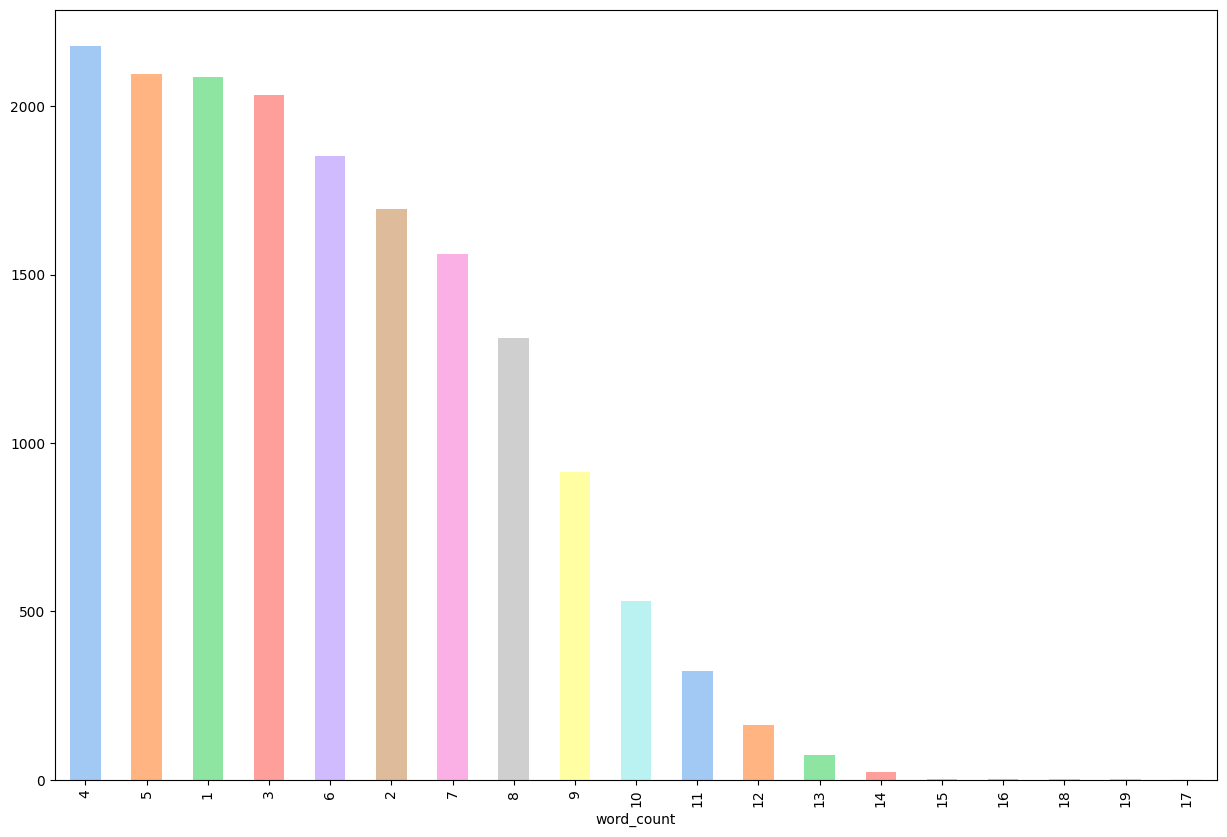

In [1009]:
plt.figure(figsize=(15,10))
data['word_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [1010]:
data['char_count'] = data['correct_text'].str.len()

<Axes: xlabel='char_count'>

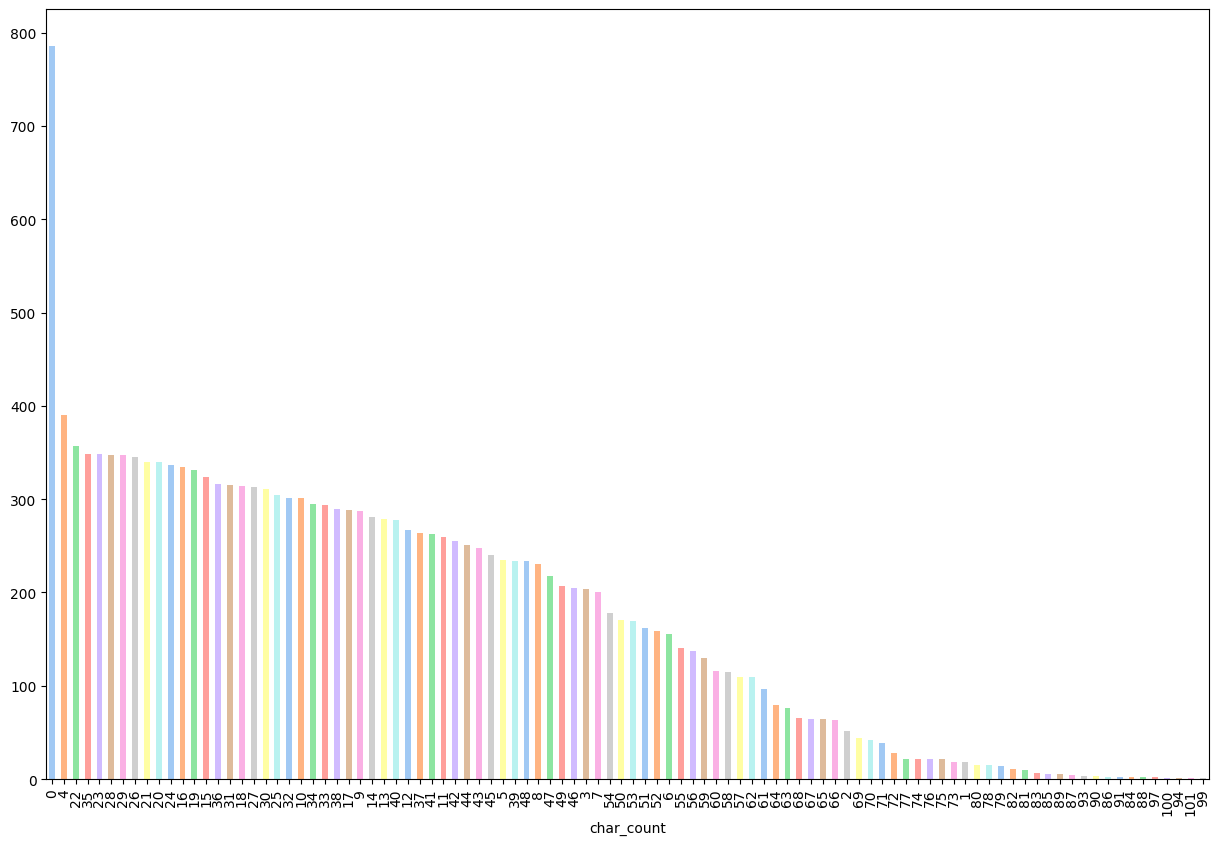

In [1011]:
plt.figure(figsize=(15,10))
data['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [1012]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/(len(words)+0.000001))

data['avg_word'] = data['correct_text'].apply(lambda x: avg_word(x)).round(1)

<Axes: xlabel='avg_word'>

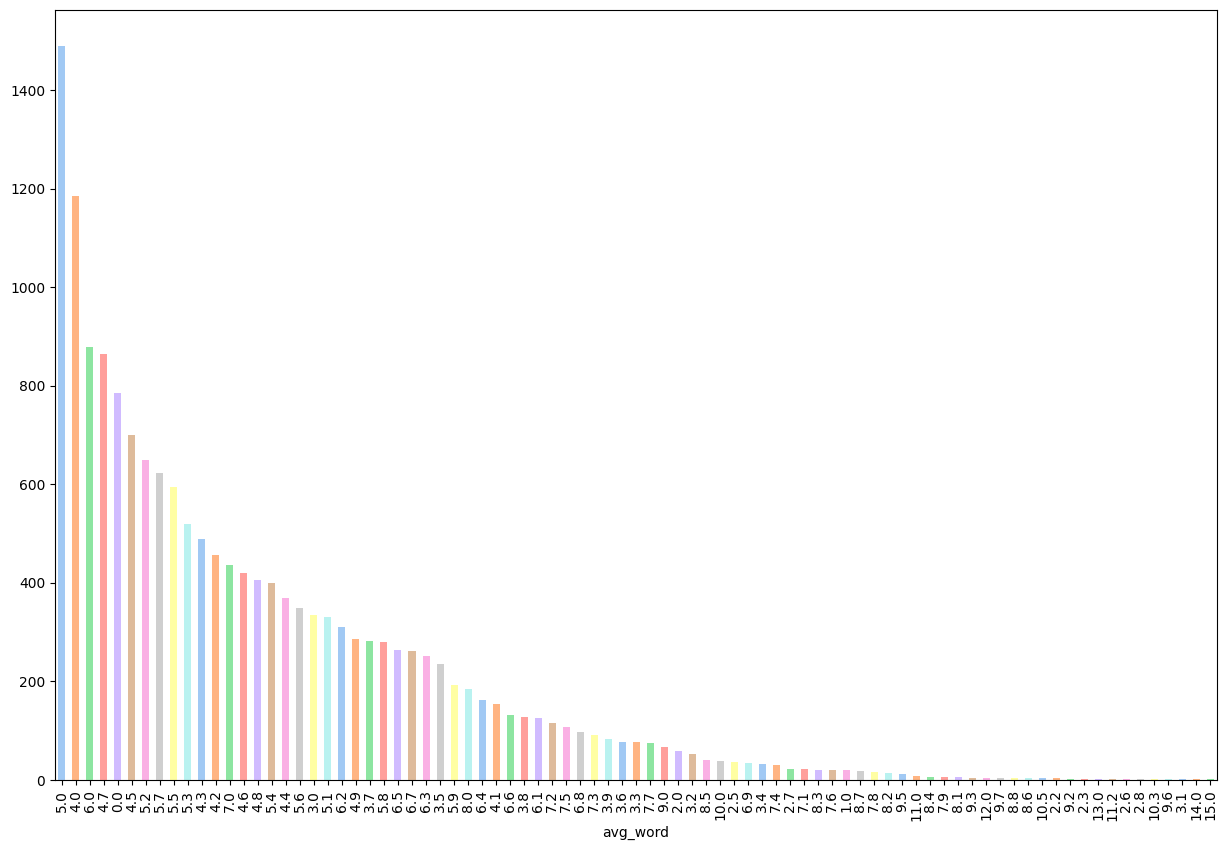

In [1013]:
plt.figure(figsize=(15,10))
data['avg_word'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

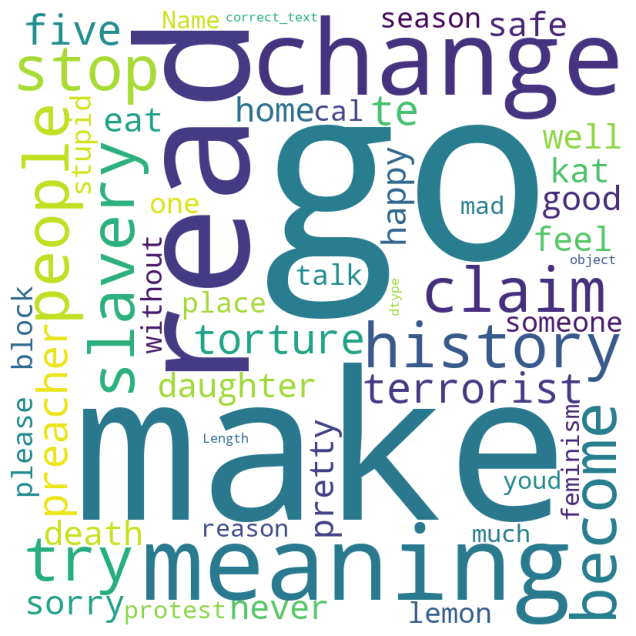

In [1014]:
g = str(data[data['oh_label']==0]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")  
plt.show()

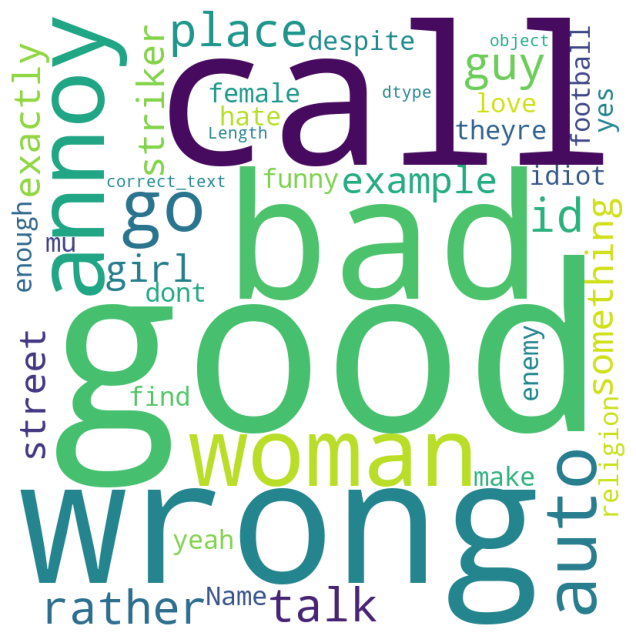

In [1015]:
g = str(data[data['oh_label']==1]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [1016]:
data.dropna(subset=['correct_text'],how='any',inplace=True)

In [1017]:
data['word_count'] = data['correct_text'].apply(lambda x: len(str(x).split(" ")))
data[['correct_text','word_count']]

,correct_text,word_count
0,read change meaning history slavery,5
1,claim people try stop become terrorist make te...,10
2,call go auto place id rather talk guy,8
3,wrong example exactly,3
4,,1
...,...,...
16846,feel sorry safe kat go home,6
16847,pretty good happy well never eat place,7
16848,lemon please go one season without someone cal...,9
16849,stupid talk block,3


In [1018]:
data['char_count'] = data['correct_text'].str.len() ## this also includes spaces
data[['correct_text','char_count']]

,correct_text,char_count
0,read change meaning history slavery,35
1,claim people try stop become terrorist make te...,64
2,call go auto place id rather talk guy,37
3,wrong example exactly,21
4,,0
...,...,...
16846,feel sorry safe kat go home,27
16847,pretty good happy well never eat place,38
16848,lemon please go one season without someone cal...,57
16849,stupid talk block,17


In [1019]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/(len(words)+0.000001))

data['avg_word'] = data['correct_text'].apply(lambda x: avg_word(x)).round(1)
data[['correct_text','avg_word']].head()

,correct_text,avg_word
0,read change meaning history slavery,6.2
1,claim people try stop become terrorist make te...,5.5
2,call go auto place id rather talk guy,3.7
3,wrong example exactly,6.3
4,,0.0


In [1020]:
data['correct_text'].replace('', np.nan, inplace=True)

In [1021]:
data.dropna(subset=['correct_text'], inplace=True)

# Corpus Assembly

In [1022]:
data

,Text,oh_label,cleaned_text,correct_text,word_count,char_count,avg_word
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in change in meaning the history o...,read change meaning history slavery,5,35,6.2
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you claim that people who tried to stop hi...,claim people try stop become terrorist make te...,10,64,5.5
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,call me but when i go to an auto place id rath...,call go auto place id rather talk guy,8,37,3.7
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong the example of and the exactly,wrong example exactly,3,21,6.3
5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,preacher who and tortured his five daughter to...,preacher torture five daughter death,5,36,6.4
...,...,...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the they should be safe a...,feel sorry safe kat go home,6,27,3.7
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,pretty good were happy with well never eating ...,pretty good happy well never eat place,7,38,4.6
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,lemon we please go just one season of without ...,lemon please go one season without someone cal...,9,57,5.4
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block,3,17,5.0


In [1023]:
X = data.drop(columns=['Text', 'oh_label','cleaned_text'])
y=data['oh_label']
print(X.shape)
print(y.shape)


(16062, 4)
(16062,)


In [1024]:
X_train_aux, X_test_aux, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.33, 
                                                            random_state=42, 
                                                            stratify=y)

In [1025]:
X_train = X_train_aux.drop(columns=['word_count','char_count','avg_word'])
X_test = X_test_aux.drop(columns=['word_count','char_count','avg_word'])

z_train = X_train_aux.drop(columns=['correct_text'])
z_test = X_test_aux.drop(columns=['correct_text'])

In [1026]:
X_train = X_train['correct_text']
X_test = X_test['correct_text']

In [1027]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

print(z_train.shape)
print(z_test.shape)

(10761,)
(5301,)
(10761,)
(5301,)
(10761, 3)
(5301, 3)


In [1028]:
vec = 'bow'
x_train, x_test = vectorize(vec, X_train, X_test, z_train, z_test)


ValueError: Shape of passed values is (10761, 5805), indices imply (10761, 4302)

In [ ]:
print(x_train.shape)

Using Word To Vec

In [ ]:
# x_train, x_test = WordToVect(X,y, z_train, z_test)

In [ ]:
y_train.value_counts().plot(kind='bar', color=sns.color_palette('pastel'))
plt.xticks([0,1],['No bullying', 'Is bullying'], rotation=0)

In [ ]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTETomek

cc = SMOTETomek(sampling_strategy='all')
X_cc, y_cc = cc.fit_resample(x_train, y_train)

In [ ]:
y_cc.value_counts().plot(kind='bar', color=sns.color_palette('pastel'))
plt.xticks([0,1],['No bullying', 'Is bullying'], rotation=0)

In [ ]:
print(X_cc.shape)
print(y_cc.shape)

print(y_cc.value_counts())

print(x_test.shape)
print(y_test.shape)


# Saving files

In [ ]:
# save_file(x_train,'X_train') 
# save_file(x_test,'X_test') 

save_file(X_cc,'X_train') 
save_file(x_test,'X_test') 


save_file(y_cc,'y_train') 
save_file(y_test,'y_test') 